# **Bias Measuring and Mitigation in Regression Tasks**

Bias in machine learning models can occur when predictions systematically deviate from the true values for certain subgroups within the dataset. This bias can arise from various sources such as unbalanced group representation in the training data, inappropriate feature selection, or flawed model specifications. This tutorial focuses on addressing bias in regression tasks.

### Measuring Bias in Regression Tasks

To measure bias, we use fairness metrics such as demographic parity, equalized odds, or equal opportunity. These metrics quantify differences in model performance across subgroups defined by sensitive attributes like gender or race.

### Mitigating Bias

Upon detecting bias, we can mitigate it using techniques categorized into three groups:
1. **Pre-processing methods:** Adjust the training data to remove bias.
2. **In-processing methods:** Modify the learning algorithm to reduce bias during training.
3. **Post-processing methods:** Adjust model predictions to eliminate bias.

This tutorial will demonstrate tools for measuring and mitigating bias in regression models through the following steps:
1. Data loading and package installation
2. Dataset preprocessing
3. Data analysis
4. Model training
5. Bias measurement
6. Bias mitigation
7. Results comparison

## **1. Data Loading and Packages Installation**

First, install the required packages. If you don't have the `holisticai` package, install it using the following command:

```bash
!pip install holisticai[all]
```

We will then import the necessary libraries.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

To ensure reproducibility and ignore warnings for cleaner outputs:

In [2]:
np.random.seed(0)
import warnings
warnings.filterwarnings("ignore")

## **2. Dataset preprocessing**

We will use the "Communities and Crime" dataset, which includes socio-economic and law enforcement data for 1994 U.S. communities. It contains demographic variables like population size, race, and education level, alongside law enforcement variables. The goal is to predict the crime rate per capita.

Source: [UCI ML repository](https://archive.ics.uci.edu/ml/datasets/communities+and+crime)

In [3]:
from holisticai.datasets import load_dataset

Using the holisticai package, we load and preprocess the dataset:

In [4]:
dataset = load_dataset('us_crime')
dataset

Dataset({
        features: ['X', 'y', 'group_a', 'group_b'],
        num_rows: 1993
    })

Check for any missing values:

In [5]:
dataset['X'].isna().sum()

state                  0
fold                   0
population             0
householdsize          0
racepctblack           0
                      ..
PctSameState85         0
LandArea               0
PopDens                0
PctUsePubTrans         0
LemasPctOfficDrugUn    0
Length: 101, dtype: int64

## **3. Data analysis**

Next, analyze the distribution of the protected groups using a pie chart.

<Axes: title={'center': 'Group proportions'}>

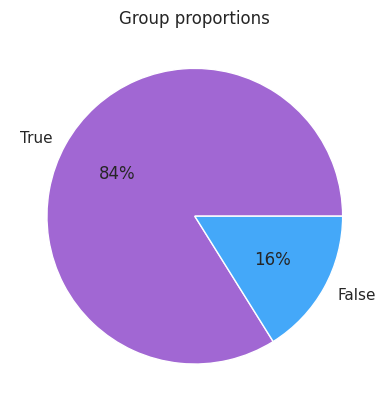

In [6]:
from holisticai.bias.plots import group_pie_plot

group_pie_plot(dataset['group_a'])

The chart shows a high proportion of white individuals (labelled as True). We also examine the features most correlated with the target variable:

<Axes: title={'center': 'Correlation matrix'}>

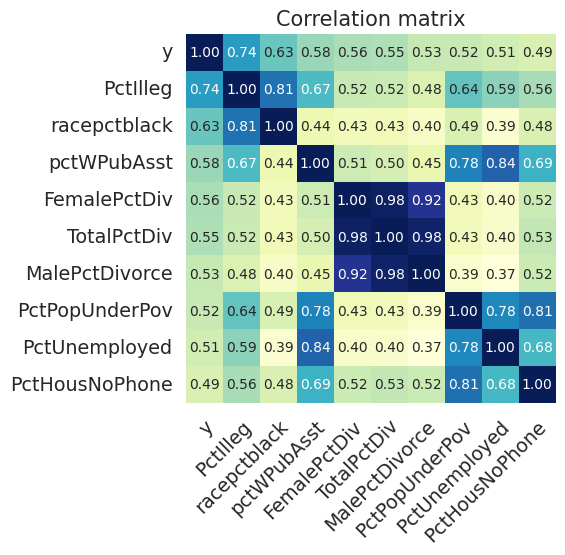

In [7]:
from holisticai.bias.plots import correlation_matrix_plot

correlation_matrix_plot(pd.concat([dataset['X'], dataset['y']], axis=1), target_feature="y", n_features=10)

Split the data into training and testing sets:

In [8]:
dataset = dataset.train_test_split(test_size=0.2, random_state=0)
train_data = dataset['train']
test_data = dataset['test']

## **4. Model training**

Train a linear regression model, ensuring the protected attributes are excluded from the training process:

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

scaler = StandardScaler()
X = scaler.fit_transform(train_data['X'])

LR = LinearRegression()
model = LR.fit(X, train_data['y'])

X = scaler.transform(test_data['X'])
y_pred = model.predict(X)

baseline_rmse = mean_squared_error(test_data['y'], y_pred, squared=False)
print(f"RMS error: {baseline_rmse}")

RMS error: 0.14166130795519824


## **5. Measuring Bias**

To evaluate the fairness of the model, we use the predictions alongside the previously defined protected groups. The `holisticai` package provides a module specifically designed for calculating various metrics that assess the fairness of algorithmic decisions. In this tutorial, we will utilize the `regression_bias_metrics` function to measure bias in our regression model.

In [10]:
from holisticai.bias.metrics import regression_bias_metrics

df = regression_bias_metrics(
    test_data['group_a'],
    test_data['group_b'],
    y_pred,
    test_data['y'],
    metric_type='both'
)
y_baseline = y_pred.copy()
df_baseline=df.copy()
df_baseline

,Value,Reference
Metric,,
Disparate Impact Q90,0.019666,1
Disparate Impact Q80,0.117994,1
Disparate Impact Q50,0.412979,1
Statistical Parity Q50,-0.705605,0
No Disparate Impact Level,0.056745,-
Average Score Difference,-0.373790,0
Average Score Ratio,0.308392,1
Z Score Difference,-2.750267,0
Max Statistical Parity,0.767257,0


Understanding the Metrics

- **Disparate Impact Q:** Ratio of success rates between protected groups. Values < 1 favor `group_a`, values > 1 favor `group_b`. Acceptable range: (0.8, 1.2).
- **Statistical Parity:** Difference in success rates between groups. Values < 0 favor `group_a`, values > 0 favor `group_b`.
- **Average Score Difference:** Difference in average scores. Negative values indicate bias against `group_a`, positive against `group_b`.
- **Z Score Difference:** Spread in Z-scores, normalized version of Disparate Impact.
- **Max Statistical Parity:** Maximum absolute statistical parity over all thresholds. Values < 0.1 (absolute) are acceptable.
- **RMSE Ratio:** RMSE for protected groups. Lower values favor `group_a`, higher favor `group_b`.
- **MAE Ratio:** Similar to RMSE Ratio.
- **Correlation Difference:** Difference in prediction-target correlation between groups. Positive values favor `group_a`, negative favor `group_b`.

## **6. Bias Mitigation**

After identifying that the model metrics deviate significantly from the desired values, we need to apply strategies to mitigate the bias present in the model.

There are various bias mitigation strategies categorized into three types: *Pre-processing*, *In-processing*, and *Post-processing* methods. The `holisticai` library offers a range of algorithms for bias mitigation across these categories. A notable feature is their compatibility with the `Scikit-learn` package, ensuring ease of use for those familiar with Scikit-learn. Implementation can follow traditional methods or be integrated into a pipeline, as we will demonstrate.

### **Pre-processing: Correlation Remover**

First, we will implement the "Correlation Remover" method, a pre-processing algorithm that modifies the original dataset. This technique removes all correlations with sensitive attributes by applying a linear transformation to the non-sensitive feature columns.

In [11]:
from holisticai.bias.mitigation import CorrelationRemover

In [12]:
model = LinearRegression()

scaler = StandardScaler()
X = scaler.fit_transform(train_data['X'])

corr = CorrelationRemover()
processed_data = corr.fit_transform(X, train_data['group_a'], train_data['group_b'])

model.fit(processed_data, train_data['y'])

X = scaler.transform(test_data['X'])

processed_data = corr.transform(X, test_data['group_a'], test_data['group_b'])

y_pred = model.predict(processed_data)

df = regression_bias_metrics(
    test_data['group_a'],
    test_data['group_b'],
    y_pred,
    test_data['y'],
    metric_type='both'
)
df_correm =df.copy()
df_correm

,Value,Reference
Metric,,
Disparate Impact Q90,0.144811,1
Disparate Impact Q80,0.216323,1
Disparate Impact Q50,0.530973,1
Statistical Parity Q50,-0.470206,0
No Disparate Impact Level,0.072893,-
Average Score Difference,-0.243671,0
Average Score Ratio,0.433022,1
Z Score Difference,-1.552591,0
Max Statistical Parity,0.523894,0


Evaluate RMSE:

In [13]:
correm_rmse = mean_squared_error(dataset['test']['y'], y_pred, squared=False)
print("RMS error: {}".format(correm_rmse))

RMS error: 0.15193137995127576


### **In-processing: Exponentiated Gradient**

Next, we will implement the "Exponentiated Gradient Reduction" method, an in-processing technique. This approach reduces fair classification to a series of cost-sensitive classification problems, resulting in a randomized classifier with the lowest empirical error while adhering to fair classification constraints.

In [14]:
from holisticai.bias.mitigation import ExponentiatedGradientReduction

In [15]:
model = LinearRegression()
inprocessing_model = ExponentiatedGradientReduction(constraints="BoundedGroupLoss", 
                                         loss='Square', min_val=-0.1, max_val=1.3, upper_bound=0.001,
                                         ).transform_estimator(model)

scaler = StandardScaler()
X = scaler.fit_transform(train_data['X'])

inprocessing_model.fit(X, train_data['y'], train_data['group_a'], train_data['group_b'])

X = scaler.transform(test_data['X'])

y_pred = inprocessing_model.predict(X)

df = regression_bias_metrics(
    test_data['group_a'],
    test_data['group_b'],
    y_pred,
    test_data['y'],
    metric_type='both'
)
df_exp_grad = df.copy()
df_exp_grad

,Value,Reference
Metric,,
Disparate Impact Q90,0.058997,1
Disparate Impact Q80,0.144811,1
Disparate Impact Q50,0.455120,1
Statistical Parity Q50,-0.627139,0
No Disparate Impact Level,0.024584,-
Average Score Difference,-0.372666,0
Average Score Ratio,0.303989,1
Z Score Difference,-1.990870,0
Max Statistical Parity,0.698673,0


Evaluate RMSE:

In [16]:
expgrad_rmse = mean_squared_error(test_data['y'], y_pred, squared=False)
print("RMS error: {}".format(expgrad_rmse))

RMS error: 0.16866594068862525


### **Post-processing: Wasserstein Barycenters**

Finally, we will implement the "Wasserstein Barycenter" method, a post-processing technique. This method identifies the optimal fair predictor by computing the Wasserstein barycenter of the distributions induced by the standard regression function across sensitive groups.

In [17]:
from holisticai.bias.mitigation import WassersteinBarycenter

In [18]:
model = LinearRegression()
model.fit(train_data['X'], train_data['y'])
y_pred = model.predict(train_data['X'])

post_processer = WassersteinBarycenter()
post_processer.fit_transform(y_pred, train_data['group_a'], train_data['group_b'])

y_pred = model.predict(test_data['X'])

y_pred = post_processer.transform(y_pred, test_data['group_a'], test_data['group_b'])['y_pred']

df = regression_bias_metrics(
    test_data['group_a'],
    test_data['group_b'],
    y_pred,
    test_data['y'],
    metric_type='both'
)
df_wb = df.copy()
df_wb

,Value,Reference
Metric,,
Disparate Impact Q90,0.609636,1
Disparate Impact Q80,0.655908,1
Disparate Impact Q50,0.806293,1
Statistical Parity Q50,-0.097493,0
No Disparate Impact Level,0.237503,-
Average Score Difference,-0.033650,0
Average Score Ratio,0.868239,1
Z Score Difference,-0.247357,0
Max Statistical Parity,0.180678,0


Evaluate RMSE:

In [19]:
expgrad_rmse = mean_squared_error(test_data['y'], y_pred, squared=False)
print("RMS error: {}".format(expgrad_rmse))

RMS error: 0.18983097230624268


## **7. Results comparison**

Now, we compare the results from the baseline model and the three bias mitigation techniques (Preprocessing, Inprocessing, Postprocessing).

**Performance Metrics Overview**

Below is a table summarizing key fairness metrics for the baseline model and each bias mitigation technique:

In [20]:
result = pd.concat([df_baseline, df_correm, df_exp_grad, df_wb], axis=1).iloc[:, [0,2,4,6,1]]
result.columns = ['Baseline','Correlation remover',"Exponentiated gradient", "Wasserstein barycenters", 'Reference']
result

,Baseline,Correlation remover,Exponentiated gradient,Wasserstein barycenters,Reference
Metric,,,,,
Disparate Impact Q90,0.019666,0.144811,0.058997,0.609636,1
Disparate Impact Q80,0.117994,0.216323,0.144811,0.655908,1
Disparate Impact Q50,0.412979,0.530973,0.455120,0.806293,1
Statistical Parity Q50,-0.705605,-0.470206,-0.627139,-0.097493,0
No Disparate Impact Level,0.056745,0.072893,0.024584,0.237503,-
Average Score Difference,-0.373790,-0.243671,-0.372666,-0.033650,0
Average Score Ratio,0.308392,0.433022,0.303989,0.868239,1
Z Score Difference,-2.750267,-1.552591,-1.990870,-0.247357,0
Max Statistical Parity,0.767257,0.523894,0.698673,0.180678,0


Overall, for this particular case, the bias mitigation techniques demonstrate varying degrees of success in improving fairness metrics compared to the baseline model. The **Wasserstein Barycenters** method consistently outperforms the others across most metrics, closely approaching the reference values and significantly reducing bias. The **Correlation Remover** also shows notable improvements but to a lesser extent. The **Exponentiated Gradient** method, while better than the baseline, is less effective compared to the other two methods. This analysis highlights the importance of choosing the appropriate bias mitigation strategy to achieve fairer model predictions.

## **Summary**

In this tutorial, we could observe how to address and mitigate bias in machine learning models for the regression task case. We utilized the `holisticai` library for this purpose to measure bias in our baseline model, using a variety of fairness metrics. Observing substantial bias, we explored three categories of bias mitigation techniques: pre-processing, in-processing, and post-processing. Specifically, we implemented the Correlation Remover as a pre-processing technique, the Exponentiated Gradient as an in-processing method, and the Wasserstein Barycenters as a post-processing strategy. Finally, we compared the performance of these mitigators against the baseline model. Our results showed that while all methods improved fairness to some extent, the Wasserstein Barycenters technique achieved the most significant reduction in bias across various metrics. 

For more information about other bias mitigation techniques and advanced features consult the `holisticai` documentation.